# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **Shift + Enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of Python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Portfolio Strategy based on Kelly Criterion

In this notebook, you will learn how to create a Kelly portfolio. 
The process for doing that is as follows:
1. Import the libraries and data 
2. Calculate the daily returns
3. Create the Kelly criterion
4. Create the Kelly portfolio

## Import the libraries and data

#### Import the libraries

You need the numpy and pandas to store the stock price data and for performing mathematical calculations.
The matplotlib library is needed for visualising the data. The cvxpy library is used to optimize the Kelly criterion and get the best weight combination. pandas.plotting is needed to avoid any warnings that may be thrown while plotting the pandas data using matplotlib.

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Import the data

You can read the stock data for companies Chevron (ticker: CVX) and IBM (ticker: IBM), using a csv file. This data contains the close prices for the two stocks starting from January-2011 to March-2017. This CSV file can be downloaded from the last unit of this course.

In [2]:
# Read the data from a csv file and specify the first column 'date' as the index
df = pd.read_csv(
    '../data_modules/Stock_Prices_2011_To_2017_Kelly_Portfolio.csv', index_col=[0])

# Convert the date column to datetime format
df.index = pd.to_datetime(df.index, format='%d-%m-%Y').date

In [3]:
df.head()

,CVX,IBM
2011-01-03,71.663479,122.660475
2011-01-04,71.398463,122.793548
2011-01-05,71.273750,122.302840
2011-01-06,70.689155,123.641892
2011-01-07,71.078885,123.034744


## Calculate the daily returns

While optimizing the Kelly Criterion, you multiply the daily returns of the stocks with their corresponding weights to get the returns of the portfolio. For the first step towards calculating the Kelly criterion, you will create a dataframe that will contain the daily percentage change of each of the stocks.

In [4]:
# Calculate the daily percentage change of both the stocks
df_change = df.pct_change()

In [5]:
# Print the top 5 rows of the dataframe
df_change.head()

,CVX,IBM
2011-01-03,NaN,NaN
2011-01-04,-0.003698,0.001085
2011-01-05,-0.001747,-0.003996
2011-01-06,-0.008202,0.010949
2011-01-07,0.005513,-0.004911


In [6]:
# Drop the first row containing the null values
df_change.dropna(inplace=True)

# Calculate the cumulative percentage returns of each stock
df_cumulative_returns = (df_change+1).cumprod()*100

In [7]:
# Print the top 5 rows of the dataframe
df_cumulative_returns.head()

,CVX,IBM
2011-01-04,99.630194,100.108489
2011-01-05,99.456167,99.708435
2011-01-06,98.640418,100.800109
2011-01-07,99.184251,100.305126
2011-01-10,98.335871,100.108489


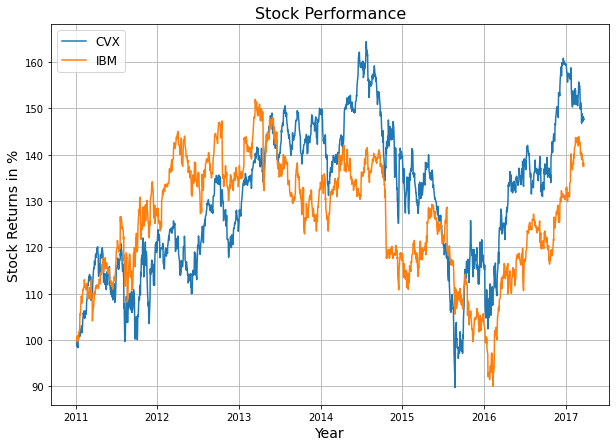

In [8]:
# Plot the returns of both the stocks
plt.figure(figsize=(10, 7))
for column in df_change.columns.values:
    plt.plot(df_change.index, df_cumulative_returns[column], label=column)

plt.legend(loc='best', fontsize=12)
plt.title('Stock Performance', fontsize=16)
plt.ylabel('Stock Returns in %', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid()
plt.show()

## Create the Kelly Criterion

Each stock in the portfolio has a certain percentage weight of the capital allocated to it. So, while optimizing the weights of each stock in the portfolio, you need to create an array of weights that has the same number of weight variables as the number of stocks. You can get the number of the stocks in the portfolio using the below command.

In [9]:
df_change.shape[1]

2

In [10]:
# Save the number of stocks in a variable
no_of_stocks = df_change.shape[1]
no_of_stocks

2

You can use the cvxpy library to create an array containing weight variables. You need to specify the number of stocks as the input for this function.

In [11]:
weights = cp.Variable(no_of_stocks)
weights.shape

(2,)

While calculating the portfolio returns of a day, you need to multiply the stock returns with the corresponding weight allocation, as shown below.

`@` is used in `cvxpy` for matrix-matrix multiplication.

In [12]:
(np.array(df_change)@weights)

Expression(AFFINE, UNKNOWN, (1566,))

In [13]:
# Save the portfolio returns in a variable
portfolio_returns = (np.array(df_change)@weights)
portfolio_returns

Expression(AFFINE, UNKNOWN, (1566,))

The expression expr1@expr2 is affine in CVXPY when one of the expressions is a constant, and expr1/expr2 is affine when expr2 is a scalar constant.

#### Kelly Criterion

The final portfolio value or the utility of the portfolio can be computed using the logarithmic summation of the daily portfolio returns.

In [14]:
final_portfolio_value = cp.sum(cp.log(1+portfolio_returns))
final_portfolio_value

Expression(CONCAVE, UNKNOWN, ())

The output tells us that the final_portfolio_value is an expression and is concave in nature and its value is unknown 

The objective of this exercise is to maximise the Kelly criterion. To do this, you can create a parameter called 'objective' and assign the maximisation condition to it. The Maximize function of the cvxpy library is used for this purpose.

In [15]:
objective = cp.Maximize(final_portfolio_value)
objective

Maximize(Expression(CONCAVE, UNKNOWN, ()))

The output tells us that the objective is a Maximize function over an expression and the expression is concave in nature and its value is unknown 

Before you solve the objective, you need to remember that there are certain constraints on the weights of the portfolio.

1. The weights should positive, as you are considering only a long-only scenario.
2. The sum of weights should be less than or equal to 1, as you are not considering leveraging.

In [16]:
constraints = [0.0 <= weights, cp.sum(weights) == 1]
constraints

[Inequality(Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))]

Here the constraints specify that the first one is an inequality constraint and its value is a constant zero. While the second is an equality constraint between an affine expression whose value is equal to a constant non-negative value

Now, you can combine both the objective and the constraints to create a problem statement. You can do this by using the Problem class of the cvxpy library, as shown below.

In [17]:
problem = cp.Problem(objective, constraints)
problem

Problem(Maximize(Expression(CONCAVE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))])

Here the output describes the entire problem including all the previously described expression into a one single statement

You can use the solve method of the problem class to get the best weight combination as shown below

In [18]:
# The optimal objective value is returned by `prob.solve()`.
problem.solve()

# The optimal value for w is stored in `w.value`.
print(weights.value)

[0.75692296 0.24307704]


## Create Kelly portfolio 

These weights were generated using the stock return data. Now you should create the Kelly portfolio by allocating these weights to the corresponding stocks and measure the performance of the portfolio.

You can get the daily portfolio returns on the data by multiplying the weight values with stock returns as shown.

In [19]:
kelly_portfolio_returns = ((df_change)*(weights.value)).sum(axis=1)
kelly_portfolio_returns.head()

2011-01-04   -0.002535
2011-01-05   -0.002294
2011-01-06   -0.003547
2011-01-07    0.002979
2011-01-10   -0.006951
dtype: float64

You can get the daily portfolio value buy adding 1 to the daily returns and then taking a cumulative product of the daily returns.

In [20]:
kelly_portfolio_value = (1+(kelly_portfolio_returns)).cumprod()
kelly_portfolio_value.head()

2011-01-04    0.997465
2011-01-05    0.995177
2011-01-06    0.991647
2011-01-07    0.994602
2011-01-10    0.987688
dtype: float64

You can calculate the annualised returns of the Kelly portfolio using the below formula.

In [21]:
kelly_annualized_returns = (
    (kelly_portfolio_value[-1])**(252/len(df_change)))-1

# Print the annualized returns of the Kelly portfolio
kelly_annualized_returns

0.06611823300866226

Now, you can compare the performance of the Kelly portfolio with that of the equal weight portfolio. To do this, you need to create an equal weight portfolio by giving 50% to each of the stocks or by simply taking the average of their returns.

In [22]:
equal_weight_portfolio = (1+((df_change).mean(axis=1))).cumprod()
equal_weight_portfolio.head()

2011-01-04    0.998693
2011-01-05    0.995826
2011-01-06    0.997193
2011-01-07    0.997494
2011-01-10    0.992250
dtype: float64

#### Performance of  Kelly portfolio

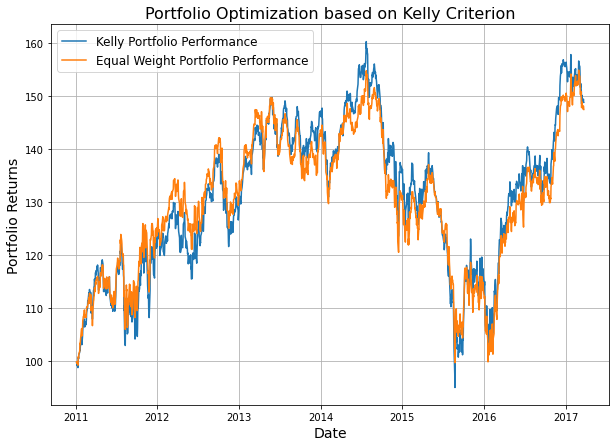

In [23]:
# Plot the percentage returns of Kelly and Equal Weight portfolios
plt.figure(figsize=(10, 7))
plt.plot(kelly_portfolio_value*100, label='Kelly Portfolio Performance')
plt.plot(equal_weight_portfolio*100,
         label='Equal Weight Portfolio Performance')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Returns', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.title('Portfolio Optimization based on Kelly Criterion', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

**Points to remember:**<br>

1. If one of the stocks in the portfolio outperforms all the others, then Kelly Criterion would assign the entire portfolio weight to that particular stock in order to maximise the returns.<br>

2. Kelly Criterion is very useful when deciding the capital allocation among stocks of the same sector that usually have similar performance.<br>

**What next?**<br>

1. To follow up on what you learnt in this section, you can try creating portfolios with multiple stocks from different sectors and create a Kelly portfolio of them.

2. Now that you know what Kelly criterion is you can read the latest research papers on www.SSRN.com and understand how to model your own portfolios with different constraints. 